# Data Analysis

In [31]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

## Data Collection

In [32]:
# Path to the local dataset file
DATASET_PATH = "../data/labeled.csv"

In [33]:
# Load the dataset with Pandas
df = pd.read_csv(DATASET_PATH)
print("Shape of the dataset: {}".format(df.shape))
df.head()
# NOTE: the first line of the file is considered as the header

Shape of the dataset: (5876, 433)


,frame,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,...,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,img_name,emotion
0,1,0,0.983333,1,0.208094,0.310677,-0.927457,0.011382,0.288625,-0.957375,...,0,0,0,1,0,0,0,0,S124_001_00000012,7
1,1,0,0.983333,1,0.205557,0.130654,-0.969884,-0.092547,0.182240,-0.978889,...,0,0,0,1,0,0,0,0,S062_002_00000007,7
2,1,0,0.983333,1,0.239417,0.187532,-0.952634,-0.043390,0.157066,-0.986634,...,0,0,0,1,0,0,0,0,S109_005_00000009,3
3,1,0,0.983333,1,0.052444,0.166183,-0.984699,-0.258572,0.179495,-0.949169,...,0,0,0,0,0,0,0,0,S055_001_00000007,7
4,1,0,0.983333,1,0.180229,0.099360,-0.978593,-0.206369,0.110525,-0.972212,...,0,0,0,1,0,0,0,0,S032_003_00000001,1


### Selecting the columns

In [34]:
df.columns = df.columns.str.replace('\s+', '')

selected_cols = [col for col in df.columns.values if col[:2] == 'AU']
selected_cols.insert(0,"img_name")
selected_cols.append("emotion")

data = df[selected_cols]
data.head()

,img_name,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,emotion
0,S124_001_00000012,0,0,0.0000,0,0.00000,0.0000,0,0.0,0.0000,...,0,0,0,0,1,0,0,0,0,7
1,S062_002_00000007,0,0,0.0000,0,0.00000,0.1968,0,0.0,0.3623,...,1,0,0,0,1,0,0,0,0,7
2,S109_005_00000009,0,0,0.2718,0,0.06056,1.2260,0,0.0,0.0000,...,0,0,0,0,1,0,0,0,0,3
3,S055_001_00000007,0,0,0.0000,0,0.00000,0.0000,0,0.0,0.0000,...,0,0,0,0,0,0,0,0,0,7
4,S032_003_00000001,0,0,0.0000,0,0.00000,0.7106,0,0.0,0.0000,...,1,0,0,0,1,0,0,0,0,1


In [35]:
data.describe(include='all')

,img_name,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,emotion
count,5876,5876.0,5876.0,5876.000000,5876.0,5876.000000,5876.000000,5876.0,5876.000000,5876.000000,...,5876.000000,5876.0,5876.0,5876.0,5876.000000,5876.0,5876.0,5876.000000,5876.0,5876.000000
unique,5876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,S035_005_00000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,0.0,0.514127,0.0,0.373571,0.954103,0.0,0.254850,0.525210,...,0.460347,0.0,0.0,0.0,0.555820,0.0,0.0,0.127127,0.0,4.342410
std,NaN,0.0,0.0,0.811424,0.0,0.684356,1.039061,0.0,0.533694,0.988007,...,0.498468,0.0,0.0,0.0,0.496917,0.0,0.0,0.333144,0.0,2.095144
min,NaN,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000
25%,NaN,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,3.000000
50%,NaN,0.0,0.0,0.000000,0.0,0.000000,0.654600,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,5.000000
75%,NaN,0.0,0.0,0.792300,0.0,0.428500,1.562000,0.0,0.130900,0.457500,...,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,6.000000


### Checking for any Missing Values

In [36]:
# Check if there is any missing value in the whole dataset
print("There are missing values in the dataset: {}".
     format(data.isnull().any().any()))

There are missing values in the dataset: False


## Data Exploration

### Analysis of Data Distributions: Continous Values

In [37]:
# Create a lambda function which will be applied to each entry
# of the numpy 2-D array of AxesSubplot objects
# x is a reference to an AxesSubplot object
y_labeler = lambda x: x.set_ylabel('density')
# np.vectorize() allows calling the function on each element
y_labeler = np.vectorize(y_labeler)

### Action Units regression data

/home/tonca/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/tonca/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


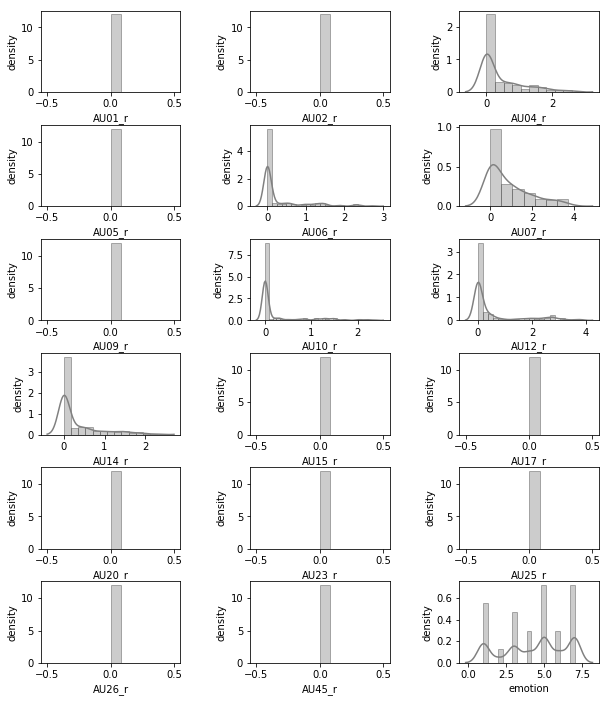

In [38]:
AUr_cols = [col for col in df.columns.values if col[:2] == 'AU' and col[-2:] == "_r"]
AUc_cols = [col for col in df.columns.values if col[:2] == 'AU' and col[-2:] == "_c"]

# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(6, 3, figsize=(10,12))
# Call the vectorized function for labeling all the y-axes
y_labeler(axes)

for i,col in enumerate(AUr_cols):
    _ = sns.distplot(data[col].sample(150), color='#808080', ax=axes[math.floor(i/3),i%3], 
                     hist_kws=dict(edgecolor="#404040", linewidth=1))
    
_ = sns.distplot(data["emotion"], color='#808080', ax=axes[5,2], 
                     hist_kws=dict(edgecolor="#404040", linewidth=1))

# Adjust space between plots
plt.subplots_adjust(wspace=.5, hspace=.4)

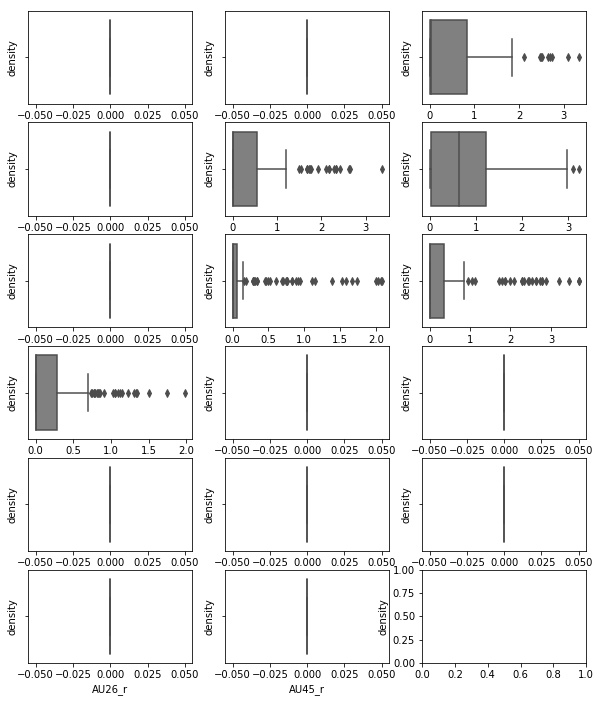

In [39]:
# Let's produce the boxplots corresponding to the distribution plots above
# Create a Figure containing 2x2 subplots
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(6, 3, figsize=(10,12))
# Call the vectorized function for labeling all the y-axes
y_labeler(axes)

for i,col in enumerate(AUr_cols):
    _ = sns.boxplot(data[col].sample(150), color='#808080', ax=axes[math.floor(i/3),i%3])

### Observations from the Plots

- Many Action Units are never activated, so we can exclude the columns that doesn't add any information in the further analysis

In [40]:
AUr_cols_sel = [AUr_cols[i] for i in [2,4,5,7,8,9]]
print(AUr_cols_sel)

['AU04_r', 'AU06_r', 'AU07_r', 'AU10_r', 'AU12_r', 'AU14_r']


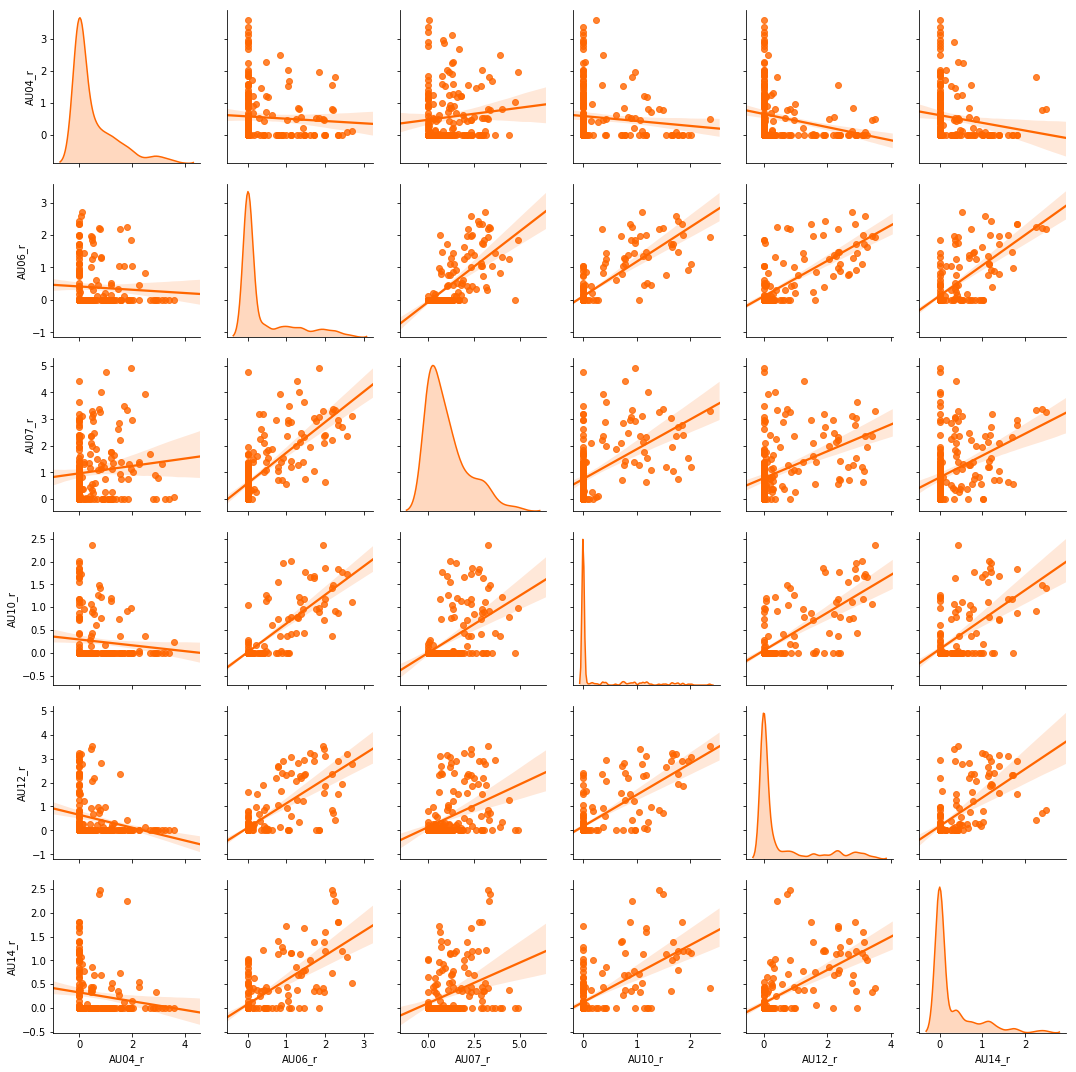

In [41]:
# Let's now plot the pairwise relationship between our continuous-valued features
_ = sns.pairplot(data[AUr_cols_sel].sample(200),
                 kind="reg",
                 diag_kind='kde', 
                 diag_kws={'shade': True, 'color': '#ff6600'}, 
                 plot_kws={'color': '#ff6600'})

/home/tonca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


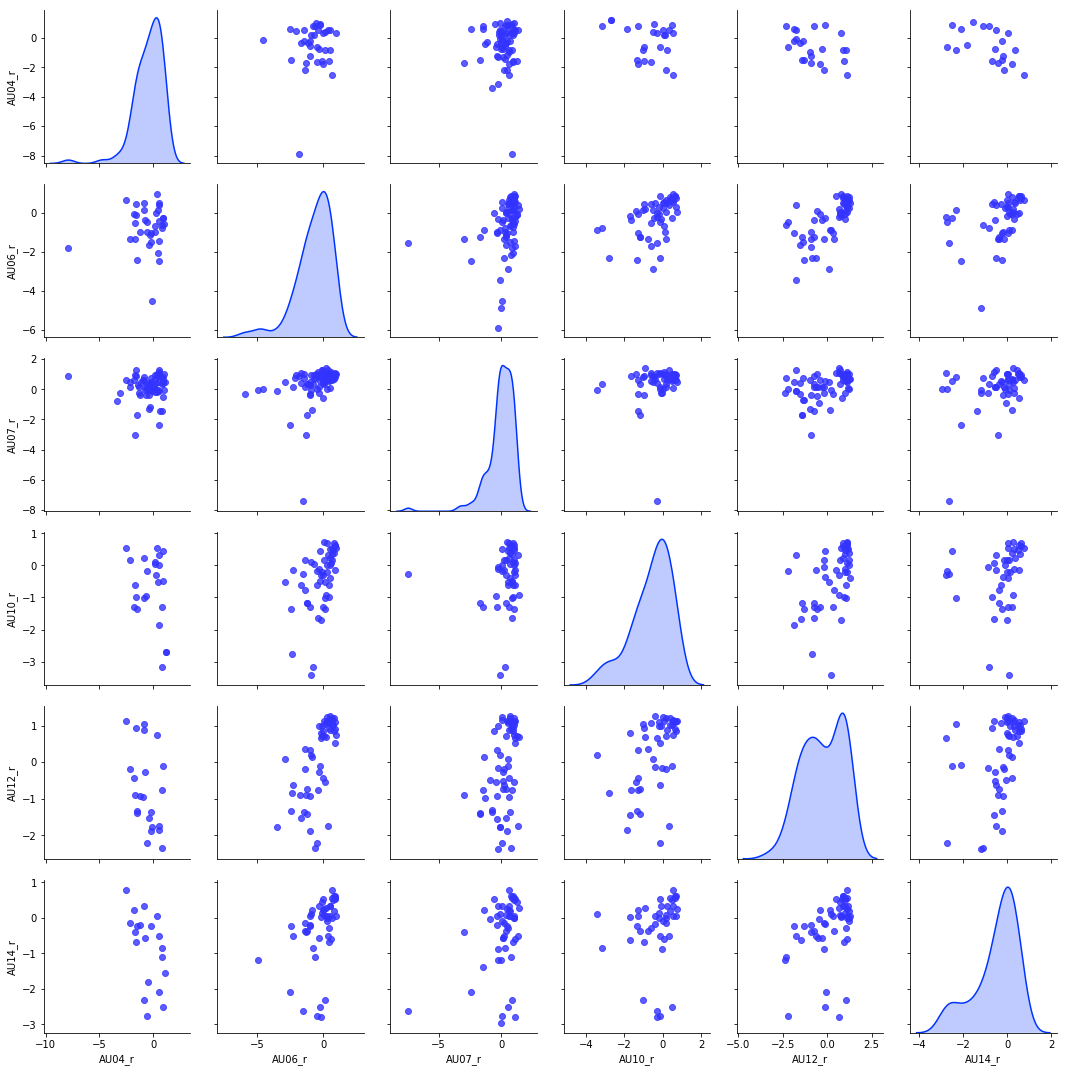

In [42]:
# Let's now plot the pairwise relationship with a log scale
_ = sns.pairplot(data[AUr_cols_sel].sample(200).apply(lambda x : np.log(x)),
                 kind="reg",
                 diag_kind='kde', 
                 diag_kws={'shade': True, 'color': '#0033ff'}, 
                 plot_kws={'color': '#3333ff'})

### Analysis of Data Distributions: Categorical Values


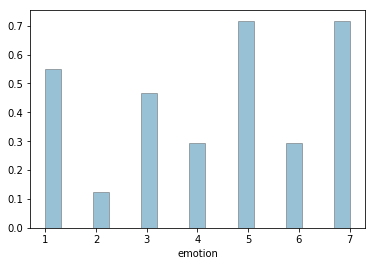

In [43]:
fig = plt.figure()
y_labeler(axes)

_ = sns.distplot(data["emotion"], color='#006699', 
                 kde=False, norm_hist=True,
                 hist_kws=dict(edgecolor="#404040", linewidth=1))

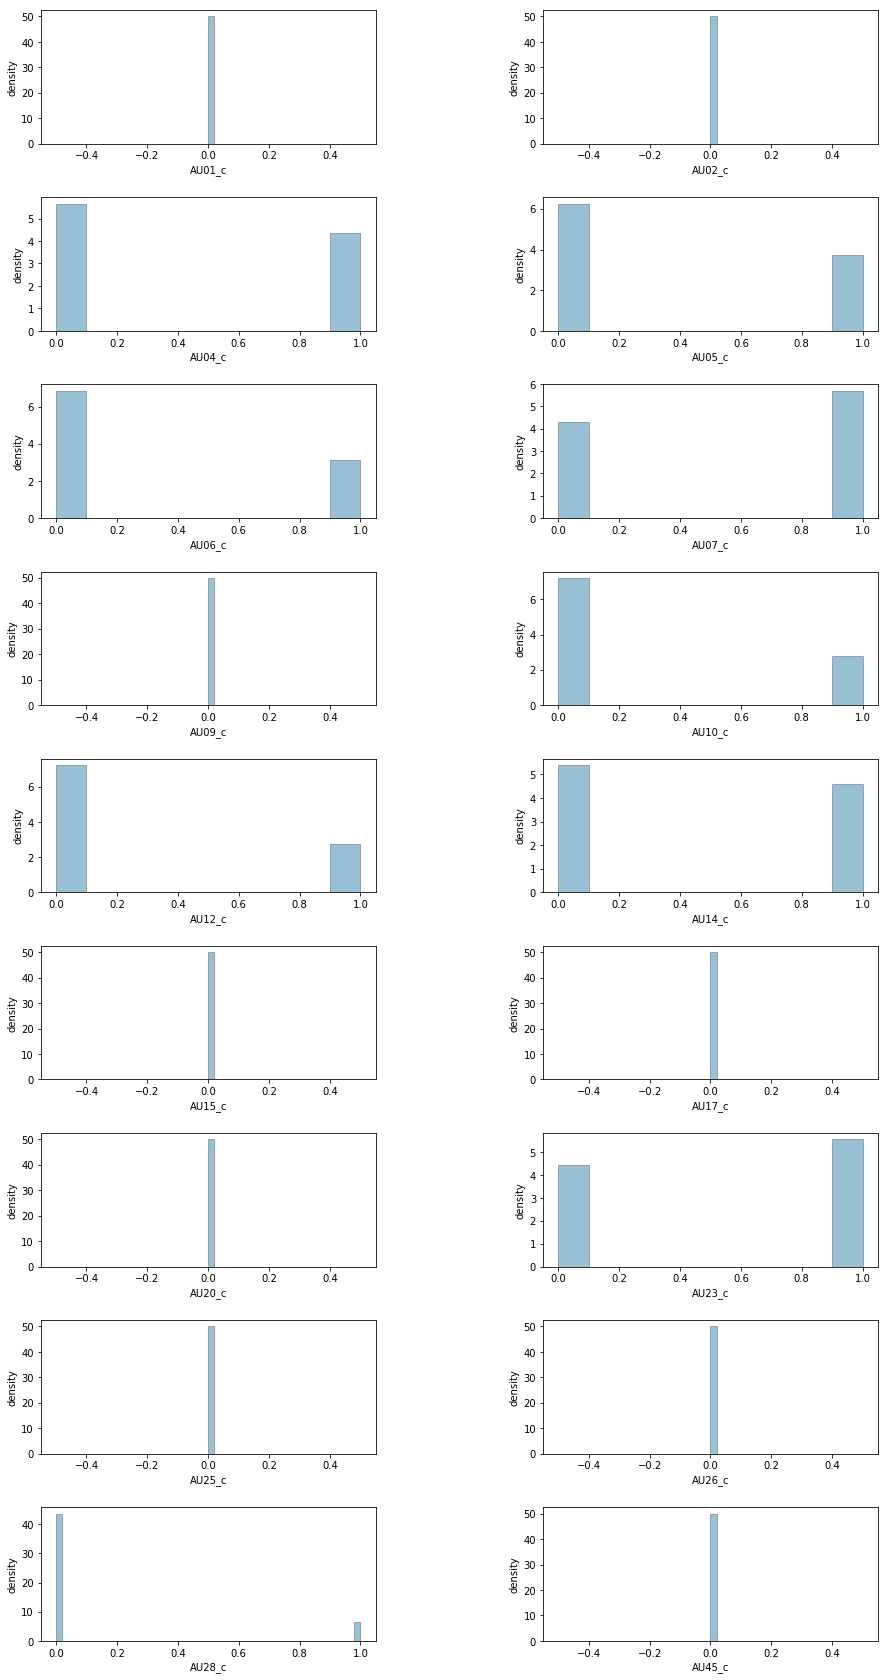

In [53]:
# Let's produce the boxplots corresponding to the distribution plots above
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(9, 2, figsize=(15,30))
y_labeler(axes)

for i,col in enumerate(AUc_cols):
    _ = sns.distplot(data[col], color='#006699', ax=axes[math.floor(i/2),i%2], 
                 kde=False, norm_hist=True,
                 hist_kws=dict(edgecolor="#404040", linewidth=1))

# Adjust space between plots
plt.subplots_adjust(wspace=.5, hspace=.4)

In [45]:
AUc_cols_sel = [AUc_cols[i] for i in [2,3,4,5,7,8,9,13,16]]
print(AUc_cols_sel)

['AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU23_c', 'AU28_c']


### Relations between variables 

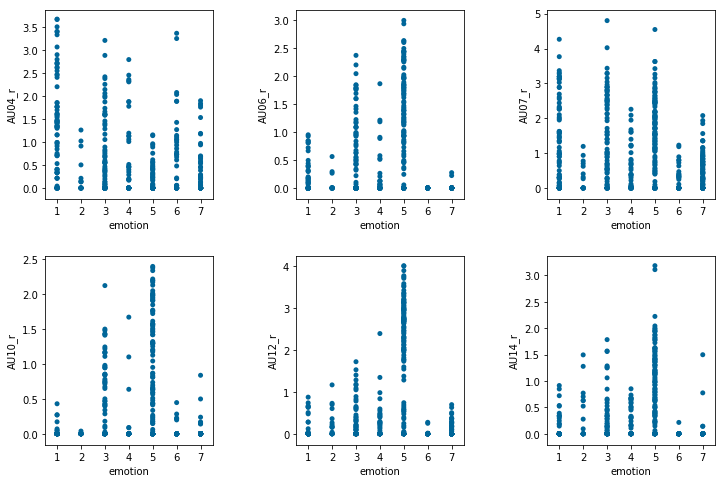

In [62]:
# stripplot is also another useful plot to relate categorical vs. target variable
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(12,8))

sample_rows = np.random.choice(df.index, 500)
for i,col in enumerate(AUr_cols_sel):
    _ = sns.stripplot(y=data[col][sample_rows], x=data.emotion[sample_rows], color='#006699', ax=axes[math.floor(i/3),i%3])

plt.subplots_adjust(wspace=.5, hspace=.3)

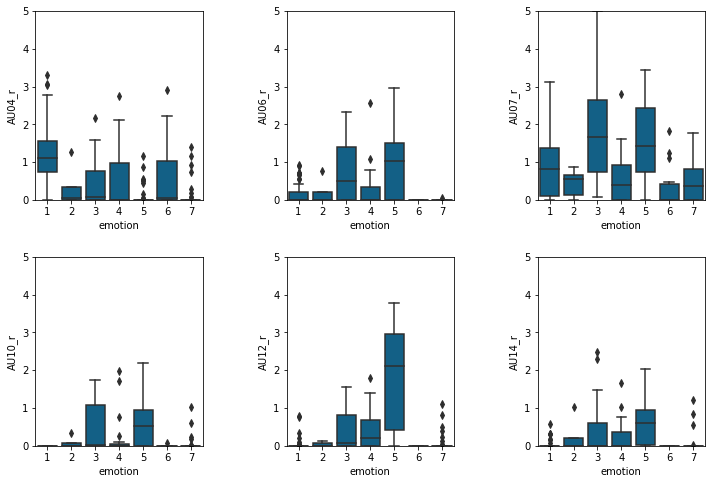

In [63]:
# boxplot is also another useful plot to relate categorical vs. target variable
# Create a Figure containing 1x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(12,8))

sample_rows = np.random.choice(df.index, 200)
for i,col in enumerate(AUr_cols_sel):
    _ = sns.boxplot(y=data[col][sample_rows], x=data.emotion[sample_rows], color='#006699', ax=axes[math.floor(i/3),i%3])
    axes[math.floor(i/3),i%3].set(ylim=(0,5))
plt.subplots_adjust(wspace=.5, hspace=.3)

### Recreate the emo-AU matrix

In [48]:
AUc_mat = [
    "AU01_c",
    "AU02_c",
    "AU04_c",
    "AU05_c",
    "AU06_c",
    "AU07_c",
    "AU09_c",
    "AU10_c",
    "AU12_c",
    "AU15_c",
    "AU17_c",
    "AU20_c",
    "AU25_c",
    "AU26_c"
]

#### Distribution of classification AUs depeding on emotion

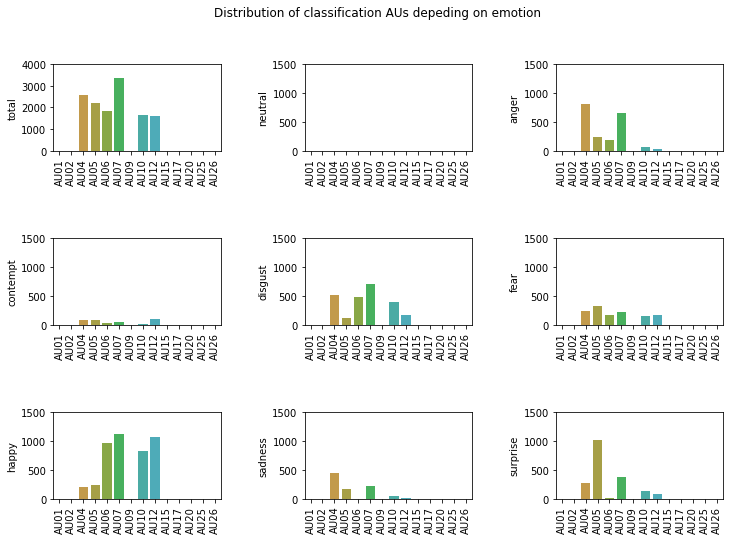

In [64]:
fig, axes = plt.subplots(3, 3, figsize=(12,8))

emo_map = { 0:'neutral',
           1:'anger',
           2:'contempt',
           3:'disgust',
           4:'fear',
           5:'happy',
           6:'sadness',
           7:'surprise'
          }

AUmat_lbl = [el[:4] for el in AUc_mat]
axes[0,0].set_ylabel("total")
axes[0,0].set(ylim=(0,4000))
_ = sns.barplot(x=AUmat_lbl,y=data.loc[:, AUc_mat].sum(), ax=axes[0,0])
for item in _.get_xticklabels():
    item.set_rotation(90)

for i in range(0,8):
    axes[math.floor((i+1)/3),(i+1)%3].set_ylabel(emo_map[i])
    axes[math.floor((i+1)/3),(i+1)%3].set(ylim=(0,1500))
    _ = sns.barplot(x=AUmat_lbl,y=data.loc[lambda data: data.emotion == i, AUc_mat].sum(), ax=axes[math.floor((i+1)/3),(i+1)%3])
    for item in _.get_xticklabels():
        item.set_rotation(90)

plt.subplots_adjust(wspace=.5, hspace=1.0)

#### Compare EMO-AU matrix with dataset distribution

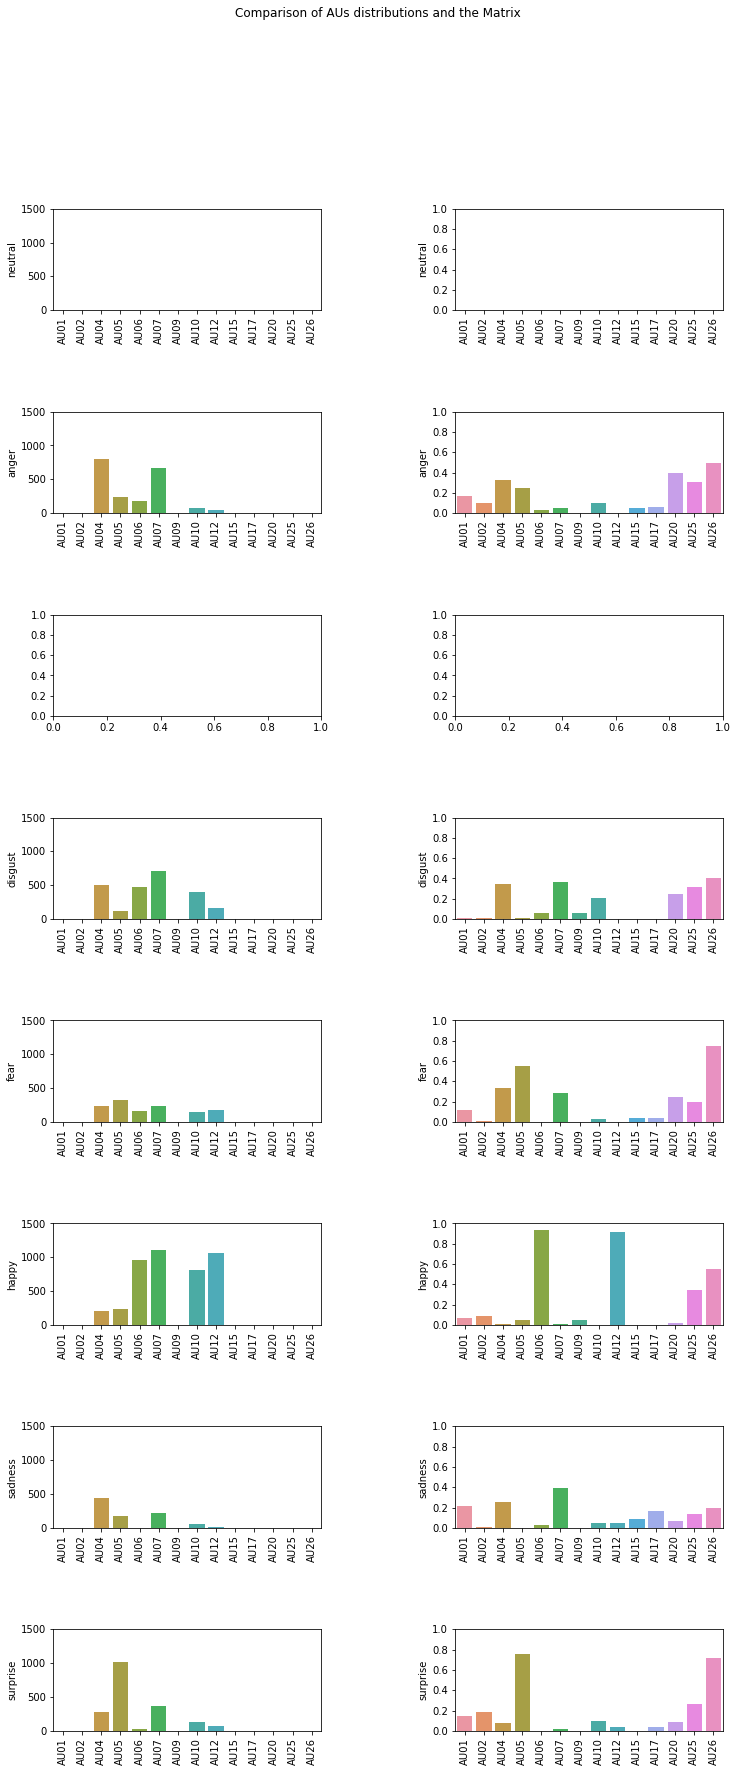

In [68]:
fig, axes = plt.subplots(8, 2, figsize=(12,28))

emo_map_inv = dict((v, k) for k, v in emo_map.items())
emo_matrix = { 'neutral': [0,0,0,0,0,0,0,0,0,0,0,0,0,0],
           'anger':    [0.17,0.1,0.33,0.25,0.03,0.05,0.,0.1,0.,0.05,0.06,0.4,0.31,0.49],
           'disgust':  [0.01,0.01,0.35,0.01,0.06,0.36,0.06,0.21,0.,0.,0.,0.25,0.32,0.40],
           'fear':     [0.12,0.01,0.33,0.55,0.00,0.29,0.,0.03,0.,0.04,0.04,0.25,0.2,0.75],
           'happy':[0.07,0.09,0.01,0.05,0.94,0.01,0.05,0.,0.92,0.,0.,0.02,0.34,0.55],
           'sadness':  [0.22,0.01,0.25,0.,0.03,0.39,0.,0.05,0.05,0.09,0.17,0.07,0.14,0.2],
           'surprise': [0.15,0.19,0.08,0.76,0.,0.02,0.,0.1,0.04,0.,0.04,0.09,0.26,0.72]
          }


for i,emo in enumerate(emo_map.values()):

    if emo in emo_matrix.keys():
        axes[i,0].set_ylabel(emo_map[i])
        axes[i,0].set(ylim=(0,1500))
        _ = sns.barplot(x=AUmat_lbl,
                        y=data.loc[lambda data: data.emotion == emo_map_inv[emo], AUc_mat].sum(),
                        ax=axes[i,0]
                       )
        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        axes[i,1].set_ylabel(emo)
        axes[i,1].set(ylim=(0,1))

        _ = sns.barplot(x=AUmat_lbl,y=emo_matrix[emo], ax=axes[i,1])

        for item in _.get_xticklabels():
            item.set_rotation(90)

plt.subplots_adjust(wspace=.5, hspace=1.0)